# Predicting Mortality in Patients with Necrotizing Fasciitis: A Machine Learning Approach

Jack B. Huber, Ph.D.<br>


# Introduction

Necrotizing fasciitis (NECK-ro-tie-zing FASH-ee-itis) (NF) is “flesh eating bacteria.” It is a rare infection of the skin and underlying tissues that afflicts an estimated 600 people in the U.S. every year. [2] If not treated quickly, NF can be deadly. The condition claims the lives of between 25% and 30% of patients diagnosed with it, which from 2003 to 2013 was an estimated 9,871 people in the United States. [3]

In recent years, as hospital systems have adopted electronic medical record systems which have collected large amounts of data, researchers have used increasingly sophisticated statistical methods to build models that predict clinical outcomes such as length of stay and mortality with high levels of accuracy. While researchers have studied other disease states such as heart failure, few if any have examined NF. Thus, this exploratory project aims to be among the first to apply unsupervised and supervised machine learning methods to study NF. This project has three primary goals:

- to identify clinically meaningful clusters of patients based on selected features
- to build a supervised machine learning model that learns from training data to predict mortality with high levels of accuracy and recall in a test data set of patients with NF
- to isolate the most important predictors of mortality

My intent is for this project to yield useful information to guide decisionmaking in a clinical setting.

# Data source
The source of data for this project is the [Medical Information Mart for Intensive Care (MIMIC)](mimic.mit.edu), a repository of publicly accessible de-identified clinical data for medical research. [4,5,6] It offers data on patients admitted to critical care units at the Beth Israel Deaconess Medical Center in Boston from 2008 to 2019.

The [MIMIC-IV-Hosp](https://mimic.mit.edu/docs/iv/modules/hosp/) module includes tables of data on diagnoses, lab results, medications, procedures, and more, from 180,733 patients admitted to the hospital. Access to these data requires [CITI training](https://about.citiprogram.org/) in research, ethics, and compliance, and the signing of a data sharing agreement. Upon completion of these requirements, the data are accessible in [Google BigQuery](https://cloud.google.com/bigquery?hl=en).

# Data extraction
In Google BigQuery I developed [this query](https://console.cloud.google.com/bigquery?sq=275328877978:3f7482f006d646748b99ddc9a27292f9) to build a data file of patients with closely related encounter diagnoses of necrotizing fasciitis (NF), Fournier gangrene, and skin and soft tissue infections, and the following features:

- **Patient demographics**, including: age and gender;
- **Patient comorbidities**, including: AIDS, cerebrovascular disease, Charlson Comorbidity Index, chronic pulmonary disease, congestive heart failure, dementia, diabetes without cc, diabetes with cc, malignant cancer, metastatic solid tumor, mild liver disease, myocardial infarct, paraplegia, peptic ulcer disease, peripheral vascular disease, renal disease, rheumatic disease, and severe liver disease;
- **Lab results**, including: anaerobic_results, glucose, hemoglobin, hematocrit, red blood cells, serum creatinine baseline, and white blood cells;
- **Surgical procedures**, including: bypass, catheter placement, closure, detachment, dilation, division, drainage, excision, extraction, fasciotomy, graft, inspection, introduction, pressure dressing, release, repair, replacement, reposition, resection, revision, supplement, transfer, transfusion, and ultrasonography;
- **Concomitant medications**, including number of serotonergic agents used,
- **Antibiotics**, including: clindamycin doses, clindamycin duration, linezolid doses, linezolid duration, and vancomycin duration; and
- **Hospital mortality**

Two criteria guided selection of these features:
- **Empirical / Data availability**. These were features on which most patients had data. Features that applied to very few patients I avoided.
- **Clinical**. I selected features measuring clindamycin and linezolid treatment based on current [1] and past [7] clinical research.

The final dataset is publicly accessible from my Google Drive Colaboratory folder as [necrot.csv](https://docs.google.com/spreadsheets/d/1LJdcP-nRabfEds08NVsmTImHe4pvShdr1rkyG6ZPRcY/edit?usp=sharing).

In [13]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tableone
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from patsy import dmatrices
from sklearn import ensemble, metrics, svm
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, ConfusionMatrixDisplay, confusion_matrix, PrecisionRecallDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from tableone import TableOne
from tabulate import tabulate

In [16]:
# Load raw data
# https://docs.google.com/spreadsheets/d/1LJdcP-nRabfEds08NVsmTImHe4pvShdr1rkyG6ZPRcY/edit#gid=1072152612

sheet_id = "1LJdcP-nRabfEds08NVsmTImHe4pvShdr1rkyG6ZPRcY"
sheet_name = "necrot"
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
df = pd.read_csv(url)

In [ ]:
df = pd.read_csv('necrot.csv')

In [17]:
# Inspect the first five rows of the dataframe
df.head()

,expired,age,d_female,aids,cerebrovascular_disease,charlson_comorbidity_index,chronic_pulmonary_disease,congestive_heart_failure,dementia,diabetes_without_cc,...,d_release_procedure,d_repair_procedure,d_replacement_procedure,d_reposition_procedure,d_resection_procedure,d_revision_procedure,d_supplement_procedure,d_transfer_procedure,d_transfusion_procedure,d_ultrasonography_procedure
0,0,61,1,0,1,8,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,53,0,0,0,6,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,56,0,0,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,47,0,0,0,2,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


# Missing data

Due to care in the SQL query process this data set is missing very little data. For the columns missing data I will impute the mean of the column values.

In [ ]:
# Column mean imputation of missing data
df["vanco_duration"].fillna(df["vanco_duration"].mean(), inplace=True)
df["anaerobic_results"].fillna(df["anaerobic_results"].mean(), inplace=True)
df["glucose"].fillna(df["glucose"].mean(), inplace=True)
df["hemoglobin"].fillna(df["hemoglobin"].mean(), inplace=True)
df["hematocrit"].fillna(df["hematocrit"].mean(), inplace=True)
df["red_blood_cells"].fillna(df["red_blood_cells"].mean(), inplace=True)
df["white_blood_cells"].fillna(df["white_blood_cells"].mean(), inplace=True)

# Convert all floats to integer
df = df.astype('int')

In [19]:
# Inspect the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   expired                         158 non-null    int64
 1   age                             158 non-null    int64
 2   d_female                        158 non-null    int64
 3   aids                            158 non-null    int64
 4   cerebrovascular_disease         158 non-null    int64
 5   charlson_comorbidity_index      158 non-null    int64
 6   chronic_pulmonary_disease       158 non-null    int64
 7   congestive_heart_failure        158 non-null    int64
 8   dementia                        158 non-null    int64
 9   diabetes_without_cc             158 non-null    int64
 10  diabetes_with_cc                158 non-null    int64
 11  malignant_cancer                158 non-null    int64
 12  metastatic_solid_tumor          158 non-null    int64
 13  mild_

The imputation procedure successully replaced all missing data and set all data types to integer. The initial working data set is therefore **57** features for **158** patients.

In [20]:
# Identify new data frame "_57" for clarity
df_57 = df

# Feature engineering
Fifty-seven is a large number of features for a small data set of only 158 cases. To consider so many features relative to the number of cases risks overfitting. Some form of data reduction is necessary. The feature engineering task is twofold. The first is to identify the most important features in the data set. These are the ones that relate most strongly to the target (of mortality) and thus most likely to contribute meaningfully to any model designed to predict mortality well. The second task is to select an appropriate number of features. Although there is no clear consensus on the optimal ratio of features to cases, a rule of thumb is the number of features should not exceed one-tenth of the sample size.

One way to select features is feature-target correlations: list features in descending order by size of correlation coefficient. This is a _filter-based_ method. This method enjoys the advantages of simplicity and transparency.

To select the most important features I use a **gradient boosting model**, which is a _model-based_ approach. This accounts for partial correlation among features. Following are the 15 features deemed "most important" by the gradient boosting model.

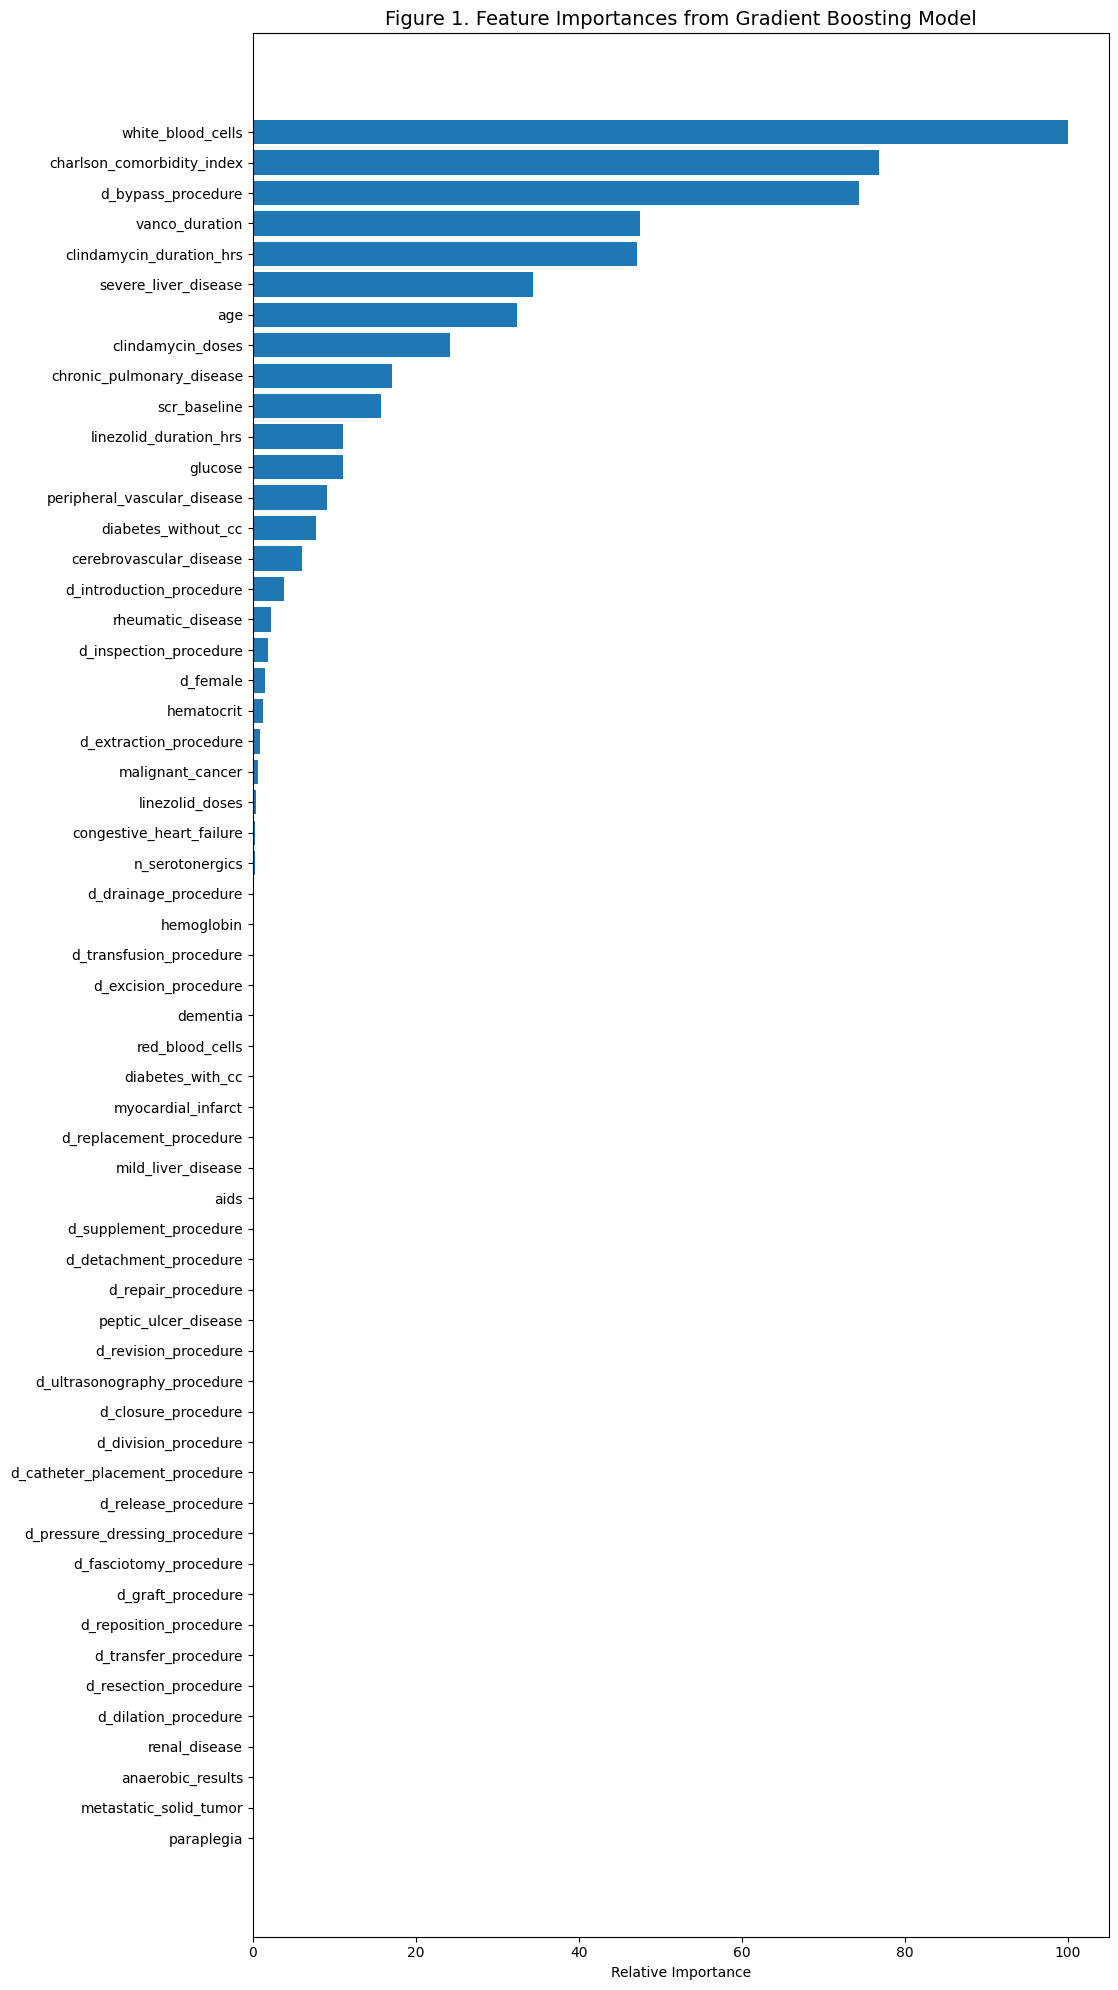

In [21]:
# Define outcome and predictors
y = df_57['expired']
X = df_57.drop(columns=['expired'])

# 500 iterations, using 2-deep trees, and loss function of 'deviance'
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'log_loss'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, y)

feature_importance = clf.feature_importances_

# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Figure 1. Feature Importances from Gradient Boosting Model', fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
# Dataframe of 15 most important features from gradient boosting model
df_15 = df_57.loc[:, [
  #target
  'expired',
  # demographics
  'age',
  # comorbidities
  'charlson_comorbidity_index',
  'severe_liver_disease',
  'peripheral_vascular_disease',
  'cerebrovascular_disease',
  # medications
  'clindamycin_duration_hrs',
  'vanco_duration',
  'clindamycin_doses',
  'linezolid_doses',
  'linezolid_duration_hrs',
  # labs
  'white_blood_cells',
  'scr_baseline',
  'glucose',
  # procedures
  'd_bypass_procedure',
  'd_extraction_procedure'
  ]]

# Unsupervised learning: Clustering
Another approach to feature engineering is data reduction by clustering. The question here is whether patients can be grouped into meaningful clusters based on the underlying statistical structure of the 15 features. I consider two clustering algorithms: **K-means** and **agglomerative** clustering.

K-means clustering works by searching for center points, called centroids, of clusters. It works by randomly choosing a few observations and making these the centroids, then: assigning each data point to its nearest centroid, creating new centroids by taking the mean of all the data points assigned to each centroid, then stopping when the difference between the old and the new centroids is lower than a given threshold value.

One metric for validating the effectiveness of clusters without a ground truth is the **Silhouette coefficient**. For each data point, the silhouette coefficient is:

>the difference between the mean distance between that data point and all other points in its cluster ( 𝑎𝑖
 ) and the mean distance between that data point and all other points in the nearest other cluster ( 𝑏𝑖
 ), divided by whichever of the two values is highest. This is the formula:
>
>>𝑏𝑖−𝑎𝑖𝑚𝑎𝑥(𝑏𝑖,𝑎𝑖)
 >
>The mean of the silhouette coefficients for all data points is the silhouette coefficient for that clustering solution on that data. Values range from -1 for very bad clusters to +1 for very dense clusters. However, if clusters employ non-flat geometry, this index will not work well.

With both approaches I consider two-cluster and three-cluster solutions. I begin by applying the algorithms to the 15 (standardized) features, ignoring the target. I then plot the results for visual inspection. Finally I report, as a cluster performance metric, the Silhouette coefficient.

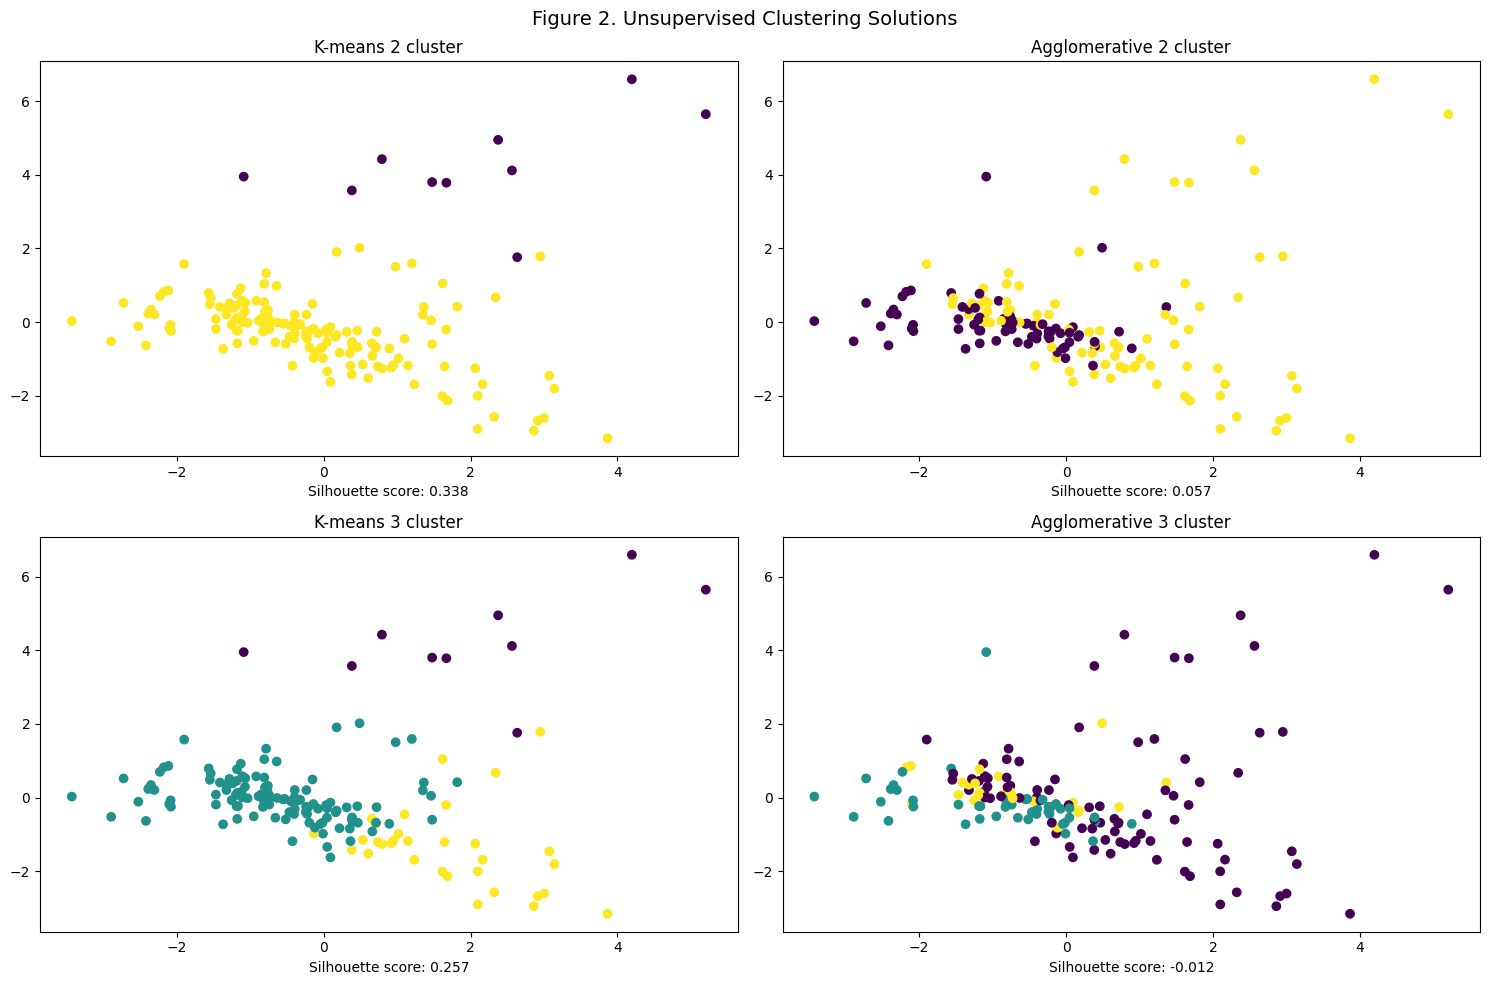

In [23]:
# Split data into target and features
X = df_15.drop(columns=['expired'])
Y = df_15['expired']
X = df_15.values

# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Extract two largest principal components to provide two planes for plotting solution
pca = PCA(n_components=2).fit_transform(X_std)

# Estimate the K-means algorithms
kmeans_2cluster = KMeans(n_clusters=2, random_state=123, n_init='auto')
kmeans_2cluster.fit(X_std)
kmeans2 = kmeans_2cluster.predict(X_std)
km2_labels = KMeans(n_clusters=2, random_state=123, n_init='auto').fit_predict(X_std)
kmeans_3cluster = KMeans(n_clusters=3, random_state=123, n_init='auto')
kmeans_3cluster.fit(X_std)
kmeans3 = kmeans_3cluster.predict(X_std)
km3_labels = KMeans(n_clusters=3, random_state=123, n_init='auto').fit_predict(X_std)

# Estimate the agglomerative clustering algorithms
agg_2cluster = AgglomerativeClustering(linkage='complete', metric='cosine', n_clusters=2)
agg_2clusters = agg_2cluster.fit_predict(X_std)
agg2_labels = AgglomerativeClustering(linkage='complete', metric='cosine', n_clusters=2).fit_predict(X_std)
agg_3cluster = AgglomerativeClustering(linkage='complete', metric='cosine', n_clusters=3)
agg_3clusters = agg_3cluster.fit_predict(X_std)
agg3_labels = AgglomerativeClustering(linkage='complete', metric='cosine', n_clusters=3).fit_predict(X_std)

# Plot solution
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Figure 2. Unsupervised Clustering Solutions', fontsize=14)
plt.subplots_adjust(bottom=0.07)
axs[0, 0].scatter(pca[:,0], pca[:,1], c=kmeans2)
axs[0, 0].set_title('K-means 2 cluster')
axs[0, 0].set_xlabel('Silhouette score: {}'.format(
    round(metrics.silhouette_score(X_std, km2_labels, metric='euclidean'),3)), fontsize=10)
axs[0, 1].scatter(pca[:,0], pca[:,1], c=agg_2clusters)
axs[0, 1].set_title('Agglomerative 2 cluster')
axs[0, 1].set_xlabel('Silhouette score: {}'.format(
    round(metrics.silhouette_score(X_std, agg2_labels, metric='euclidean'),3)), fontsize=10)
axs[1, 0].scatter(pca[:,0], pca[:,1], c=kmeans3)
axs[1, 0].set_title('K-means 3 cluster')
axs[1, 0].set_xlabel('Silhouette score: {}'.format(
    round(metrics.silhouette_score(X_std, km3_labels, metric='euclidean'),3)), fontsize=10)
axs[1, 1].scatter(pca[:,0], pca[:,1], c=agg_3clusters)
axs[1, 1].set_title('Agglomerative 3 cluster')
axs[1, 1].set_xlabel('Silhouette score: {}'.format(
    round(metrics.silhouette_score(X_std, agg3_labels, metric='euclidean'),3)), fontsize=10)
plt.tight_layout()
plt.show()

Figure 2 illustrates the visual results of the four clustering solutions.

The first solution--the K-means two-cluster solution--enjoys the highest Silhouette score of 0.349, but is grossly imbalanced with only 10 patients in the second cluster.

The second solution--the agglomerative two-cluster solution--also has a positive Silhouette score, and it does distinguish two groups of patients. But there is considerable overlap between these patients. The clusters are not linearly separable.

The third solution--the K-means three-cluster solution--also has a respectable positive Silhouette score of 0.158. It also shows three distinct groups of patients. The clusters are also linearly separable.

The final solution--the agglomerative three-cluster solution--shows a Silhouette score of -0.008, the lowest of the four. It also shows three distinct clusters of patients. But one cluster appears embedded within another. The clusters are not linearly separable. This is not a viable solution.

Based on the promising results of the K-means 3-cluster solution I will add it to the dataframe as a new feature.

In [ ]:
# Add clusters as feature to dataframe
df_16 = df_15
df_16['cluster'] = kmeans_3cluster.fit_predict(X_std)

# Rename the clusters
df_16['cluster'].replace(0, 'Cluster 1', inplace=True)
df_16['cluster'].replace(1, 'Cluster 2', inplace=True)
df_16['cluster'].replace(2, 'Cluster 3', inplace=True)

# Get dummies and add to new dataframe
df_new = pd.get_dummies(df_16['cluster'], drop_first=True)
df_17 = pd.concat([df_16, df_new], axis=1)
df_17 = df_17.drop(columns=['cluster'])
df_17['Cluster_2'] = df_17['Cluster 2']
df_17['Cluster_3'] = df_17['Cluster 3']
df_17 = df_17.drop(columns=['Cluster 2'])
df_17 = df_17.drop(columns=['Cluster 3'])

df_17['Cluster_2'].replace(False, 0, inplace=True)
df_17['Cluster_2'].replace(True, 1, inplace=True)
df_17['Cluster_3'].replace(False, 0, inplace=True)
df_17['Cluster_3'].replace(True, 1, inplace=True)

# Data exploration

### Patient characteristics

Table 1 presents descriptive information about the demographic and clinical characteristics of the patients. Patients are grouped by cluster classification.

In [ ]:
# Table 1. Demographic and Clinical Characteristics of Patient Clusters
t1_columns = [
    #target
    'expired',
    # demographics
    'age',
    # comorbidities
    'charlson_comorbidity_index',
    'severe_liver_disease',
    'peripheral_vascular_disease',
    'cerebrovascular_disease',
    # medications
    'clindamycin_duration_hrs',
    'vanco_duration',
    'clindamycin_doses',
    'linezolid_doses',
    'linezolid_duration_hrs',
    # labs
    'white_blood_cells',
    'scr_baseline',
    'glucose',
    # procedures
    'd_bypass_procedure',
    'd_extraction_procedure',
    # clusters
    'cluster']
t1_categorical = [
    # target
    'expired',
     # comorbidities
    'severe_liver_disease',
    'peripheral_vascular_disease',
    'cerebrovascular_disease',
    # procedures
    'd_bypass_procedure',
    'd_extraction_procedure'
    ]
t1_groupby = ['cluster']
t1 = TableOne(df_16, columns = t1_columns, categorical = t1_categorical, groupby = t1_groupby, pval=True, missing=False)
print('-----------------------------------------------------------------------------------')
print()
print('Table 1.')
print('Demographic and Clinical Characteristics of NF Patients')
print()
print('-----------------------------------------------------------------------------------')
t1

According to Table 2, the three patient clusters vary substantially in size. The first cluster (Cluster 1) has 10 patients which comprises 6.3 percent of sample. The second and third clusters comprise 73.4 and 20.2 percent of the patients, respectively.

Twenty of the 158 patients expired in the hospital, an overall mortality rate of 12.6 percent, and this rate varies significantly by cluster assignment. All of the patients in the first two clusters survived, and a third of the patients in the third cluster died.

The patients in the third cluster tended to have more comorbidities than patients in the first two clusters.

Patients in the first cluster received substantially more linezolid than patients in the second and third clusters. Patients in the second cluster received more vancomycin.

Patients in the first cluster were more likely to receive bypass procedures.


### Bivariate associations

Another tool for exploring relationships among features is a correlation matrix. A correlation matrix is a succinct way to examine bivariate correlations among all the features.

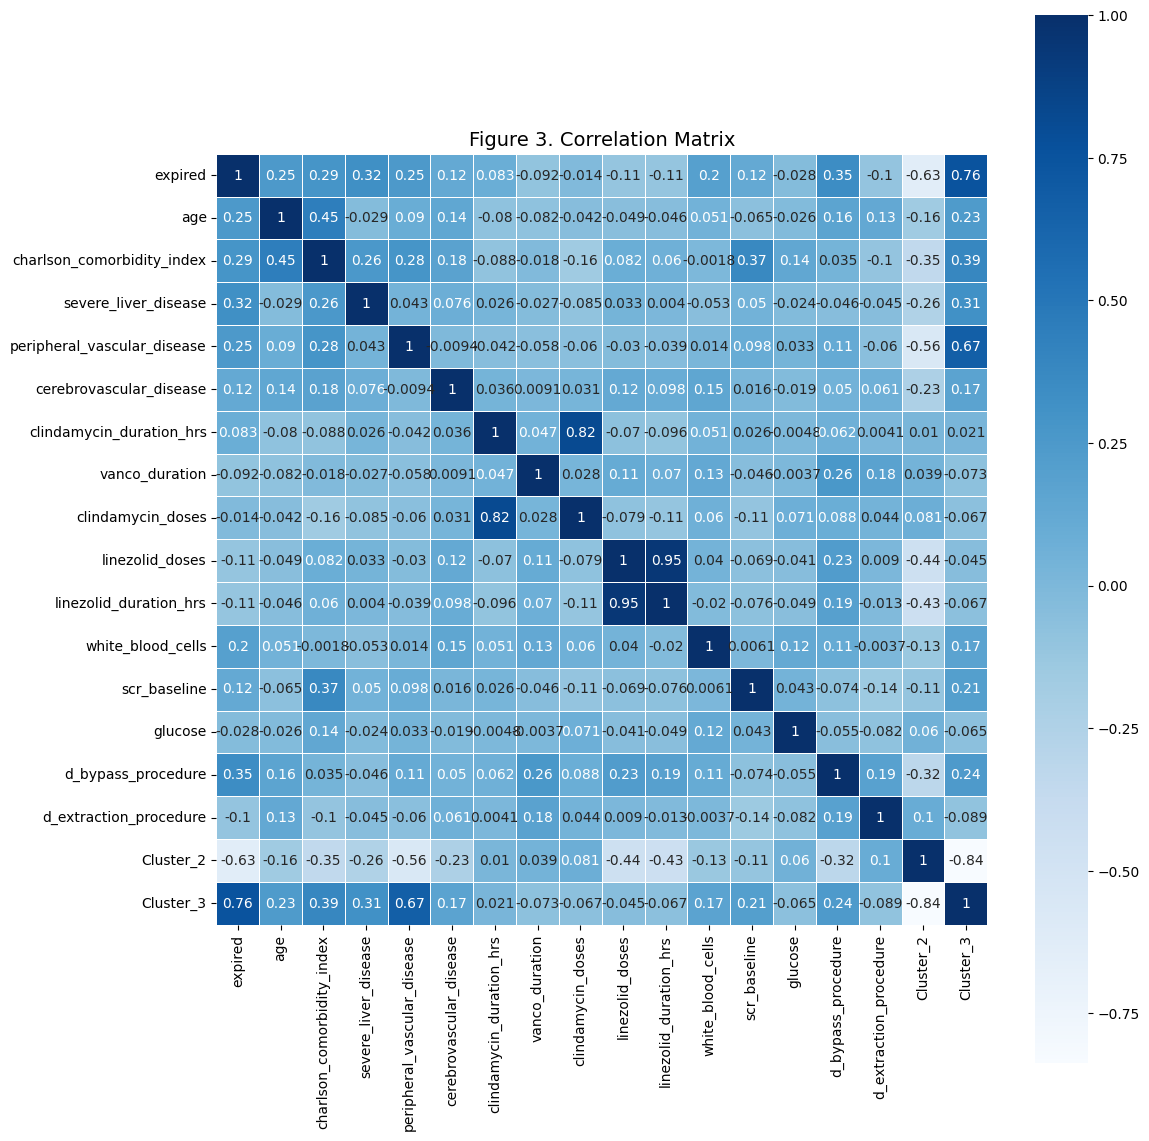

In [26]:
# Correlation matrix and heat map
corrmatrx = df_17.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corrmatrx, square=True, cmap="Blues", annot=True, linewidths=.5)
plt.title("Figure 3. Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

Here the correlation coefficients are colored by their size so that the strongest are clearer to the eye. The `expired` column illustrates the correlation coefficients of every feature with mortality.

# Supervised learning: Modeling mortality

A primary goal of the project is to model mortality in this population of patients. This means fitting a statistical model to a training data set to learn the relationships among all the features to the target, then applying this learning to a test data set to see how accurately the model can predict the outcome in the test data set. In this section I evaluate two models for this purpose: a **logistic regression** model and a **support vector machine**.

The first model is logistic regression, and I apply it for three reasons. One is that the logistic model is a linear classifier which are appropriate for cases that, as illustrated above in the scatter plot of clusters, can be separated by an imaginary line. A second reason is that the logistic model is appropriate for binary outcomes like mortality. Finally, logistic regression is also a well-known statistical method in the medical profession. I use the `sklearn.linear_model.LogisticRegression` implementation in the sci-kit learn library.[6]

The second model is a support vector machine, and I apply it for several reasons. One is that, like the logistic model, it is appropriate for linear classification tasks. Support-vector machines (SVM) are also linear classifiers. They work by attempting to construct a *hyperplane* (like a straight, 1D line in a 2D space) that, like logistic regression, separates objects into classes. However, SVMs are chiefly concerned with finding the line that has the greatest distance to the nearest training data point.

In [27]:
# Split data into target and features
X = df_17.drop(columns=['expired'])
Y = df_17['expired']
X = df_17.values

# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Extract two largest principal components to provide two planes for plotting solution
pca = PCA(n_components=2).fit_transform(X_std)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=82, shuffle=True)

In [28]:
# Fit base logistic model and gather performance metrics
lr1 = LogisticRegression(solver='lbfgs', max_iter=30000)
lr1.fit(X_train, y_train)
lr1_predictions = lr1.predict(X_test)
lr1_test_score = lr1.score(X_test, y_test) # accuracy scores
lr1_train_score = lr1.score(X_train, y_train) # accuracy scores
lr1_accuracy = accuracy_score(y_test, lr1_predictions)
lr1_precision = precision_score(y_test, lr1_predictions)
lr1_recall = recall_score(y_test, lr1_predictions)
lr1_f1 = f1_score(y_test, lr1_predictions)
lr1_fbeta_precision = fbeta_score(y_test, lr1_predictions, beta=0.5)
lr1_fbeta_recall = fbeta_score(y_test, lr1_predictions, beta=2)

# Fit base SVM and gather performance metrics
svm1 = LinearSVC(max_iter=30000, dual='auto')
svm1.fit(X_train, y_train)
svm1_predictions = svm1.predict(X_test)
svm1_train_score = svm1.score(X_train, y_train)
svm1_test_score = svm1.score(X_test, y_test)
svm1_accuracy = accuracy_score(y_test, svm1_predictions)
svm1_precision = precision_score(y_test, svm1_predictions)
svm1_recall = recall_score(y_test, svm1_predictions)
svm1_f1 = f1_score(y_test, svm1_predictions)
svm1_fbeta_precision = fbeta_score(y_test, svm1_predictions, beta=0.5)
svm1_fbeta_recall = fbeta_score(y_test, svm1_predictions, beta=2)

### Model performance
There are several ways to evaluate the quality of the model. The first and primary is the **accuracy** score which is the proportion (or percent) of all patients correctly classified (as either true positives or true negatives).

In [29]:
# Performance metrics table of base supervised learning models

pm1 = [["Accuracy",                       round(lr1_accuracy,3),        round(svm1_accuracy,3)],
       ["Precision",                      round(lr1_precision,3),       round(svm1_precision,3)],
       ["Recall",                         round(lr1_recall,3),          round(svm1_recall,3)],
       ["F1",                             round(lr1_f1,3),              round(svm1_f1,3)],
       ["Fbeta score favoring precision", round(lr1_fbeta_precision,3), round(svm1_fbeta_precision,3)],
       ["Fbeta score favoring recall",    round(lr1_fbeta_recall,3),    round(svm1_fbeta_recall,3)]
       ]

print()
print('Table 2.')
print('Test Set Performance Metrics for Base Supervised Learning Models')
print()
print('--------------------------------------------------------------------')
print(tabulate(pm1, headers=["Metric","Logistic","Support Vector Machine"]))
print('--------------------------------------------------------------------')


Table 2.
Test Set Performance Metrics for Base Supervised Learning Models

--------------------------------------------------------------------
Metric                            Logistic    Support Vector Machine
------------------------------  ----------  ------------------------
Accuracy                             0.975                     0.975
Precision                            0.8                       0.8
Recall                               1                         1
F1                                   0.889                     0.889
Fbeta score favoring precision       0.833                     0.833
Fbeta score favoring recall          0.952                     0.952
--------------------------------------------------------------------


According to Table 2, these base models are extraordinarily accurate. Based on what they learned from the training data set, they correctly classify nearly all the patients in the test set.

Arguably of greater concern is the model's performance predicting a specific group of patients: those who actually expired. Patients who were predicted to survive but actually died a false negatives. **Recall** is the proportion of negatives who were correctly predicted, which in this case represents the proportion of patients who expired who were correctly predicted. According to Table 2, all of the patients who expired were correctly predicted.

A helpful tool for visualizing model classification is the **confusion matrix**. This is a matrix of four cells of cases that illustrate, for this project:
- patients whom the model predicted would expire and actually expired (true positives)
- patients whom the model predicted would expire but survived (false positives)
- patients whom the model predicted would survive but expired (false negatives)
- patients whom the model predicted would survive and did survive (true negatives)

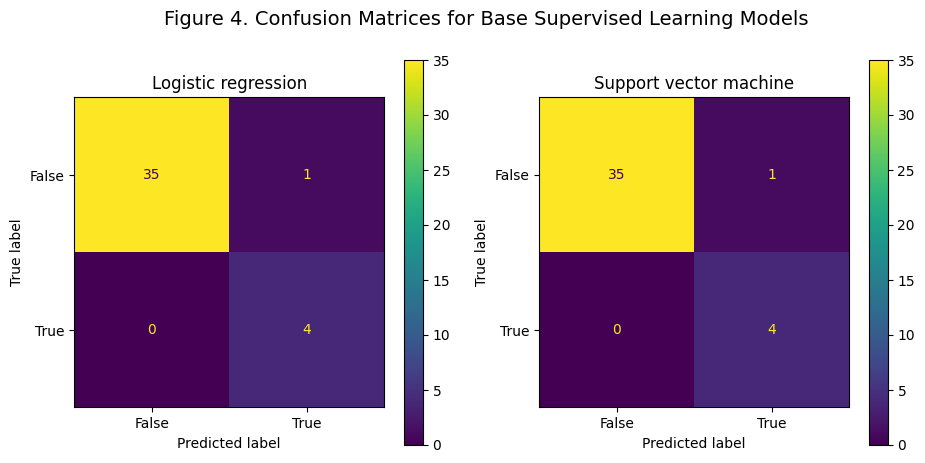

In [30]:
# Confusion matrices for first models

fig, ax = plt.subplots(1, 2, figsize=(11,5))
fig.suptitle('Figure 4. Confusion Matrices for Base Supervised Learning Models', fontsize=14)

ax[0].set_title("Logistic regression")
ax[1].set_title("Support vector machine")

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(y_test, lr1_predictions),
    display_labels=[False, True]).plot(ax=ax[0])

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(y_test, svm1_predictions),
    display_labels=[False, True]).plot(ax=ax[1])

The confusion matrix goes beyond the accuracy statistics by revealing the two sources of error in the model: the false positives and false negatives in the test set. The false positive is the patient in the upper right quadrant whom the model predicted to expire but actually survived.

**Precision** is the proportion of positive predictions that are correct. In this case, precision is 80% because four out of the five patients who were predicted to expire actually did. The recall for this model, the proportion of patients who expired who were correctly predicted, is 1.0 because the model correctly predicted all of the deaths. Precision and recall trade off; to increase one is to decrease the other. A visually helpful way to monitor this relationship is the **precision-recall curve**.

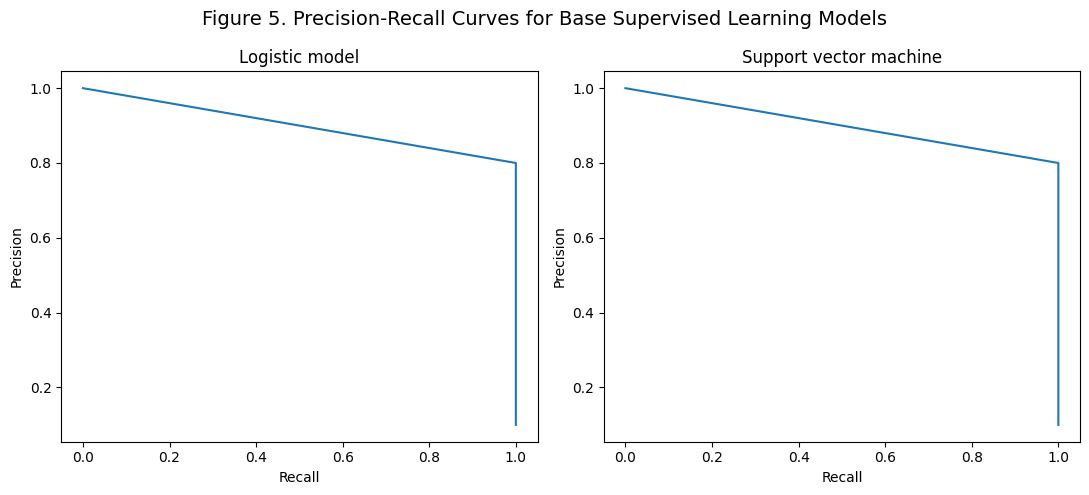

In [31]:
# Precision-recall curves
lr1_pres, lr1_rec, lr_thresholds = precision_recall_curve(y_test, lr1_predictions)
svm1_pres, svm1_rec, svm1_thresholds = precision_recall_curve(y_test, svm1_predictions)

# Plot solution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
fig.suptitle('Figure 5. Precision-Recall Curves for Base Supervised Learning Models', fontsize=14)
ax1.plot(lr1_rec, lr1_pres) # Logistic model
ax1.set_title('Logistic model')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax2.plot(svm1_rec, svm1_pres) # SVM model
ax2.set_title('Support vector machine')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
plt.tight_layout()
plt.show()

In these data, the tradeoff between precision and recall is not a clean, straight line. Efforts to improve recall come at less expense to precision up to 0.8 or so. Beyond that any effort to increase recall destroys precision. This curve is appropriate for data with imbalanced classes such as exists in this data set with the mortality rate of 12%.

### Model tuning
Although the performance of the base models are excellent, it is worth making some effort to tune the models to increase performance. The process of modifying algorithms to lower the performance gap from the training set to the test set is called _regularization_. Two ways to regularize are L2 regularization and adjustment of the C parameter.

L2 regularization modifies the cost function such that a larger penalty is imposed on larger coefficients, making the algorithm biased toward smaller coefficients.

In [32]:
# Logistic regression L2 regularization
lrl2 = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000, random_state=2)
lrl2.fit(X_train, y_train)
lrl2_predictions = lrl2.predict(X_test)
lrl2_test_score = lrl2.score(X_test, y_test) # accuracy scores
lrl2_train_score = lrl2.score(X_train, y_train) # accuracy scores
lrl2_accuracy = accuracy_score(y_test, lrl2_predictions)
lrl2_precision = precision_score(y_test, lrl2_predictions)
lrl2_recall = recall_score(y_test, lrl2_predictions)
lrl2_f1 = f1_score(y_test, lrl2_predictions)
lrl2_fbeta_precision = fbeta_score(y_test, lrl2_predictions, beta=0.5)
lrl2_fbeta_recall = fbeta_score(y_test, lrl2_predictions, beta=2)

# Logistic regression regularization table
pm2 = [["Accuracy", round(lr1_accuracy,3), round(lrl2_accuracy,3)],
       ["Precision", round(lr1_precision,3), round(lrl2_precision,3)],
       ["Recall", round(lr1_recall,3), round(lrl2_recall,3)],
       ["F1", round(lr1_f1,3), round(lrl2_f1,3)],
       ["Fbeta score favoring precision", round(lr1_fbeta_precision,3), round(lrl2_fbeta_precision,3)],
       ["Fbeta score favoring recall", round(lr1_fbeta_recall,3), round(lrl2_fbeta_recall,3)]
       ]
print()
print('Table 3.')
print('Test Set Performance Metrics for Logistic Regression Models')
print()
print('---------------------------------------------------------------------------------------------------------------------')
print(tabulate(pm2, headers=["Metric","Base Logistic Model with no regularization","Logistic Model with L2 Regularization"]))
print('---------------------------------------------------------------------------------------------------------------------')


Table 3.
Test Set Performance Metrics for Logistic Regression Models

---------------------------------------------------------------------------------------------------------------------
Metric                            Base Logistic Model with no regularization    Logistic Model with L2 Regularization
------------------------------  --------------------------------------------  ---------------------------------------
Accuracy                                                               0.975                                    0.975
Precision                                                              0.8                                      0.8
Recall                                                                 1                                        1
F1                                                                     0.889                                    0.889
Fbeta score favoring precision                                         0.833                                 

L2 regularization made no difference in the performance of the logistic model.

**C parameter tuning**

The second regularization strategy is to adjust the C parameter. 𝐶 is an inverse regularization strength parameter, meaning that lower values of 𝐶 cause stronger regularization.

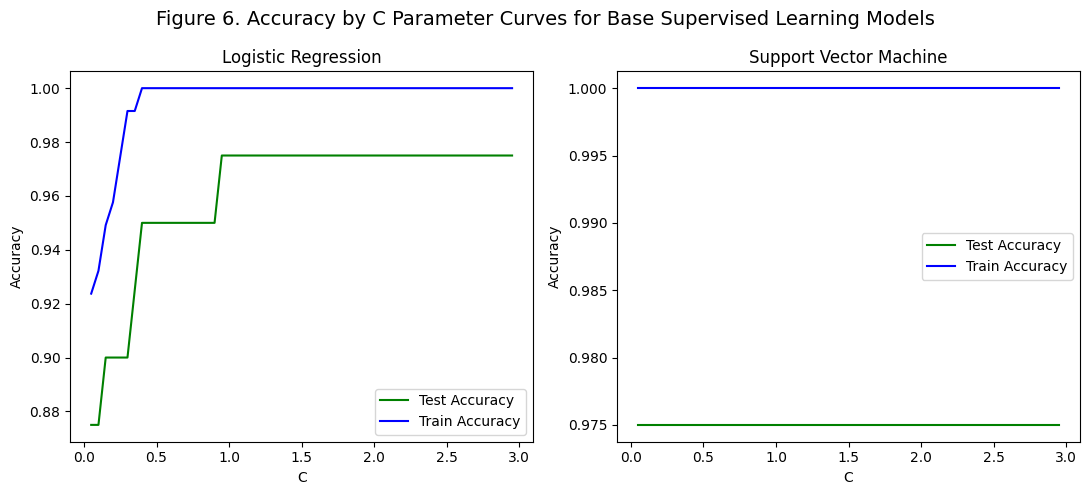

In [33]:
# Logistic Regression Model C Parameter Tuning
lr2_c_vals = np.arange(0.05, 3.0, 0.05)
lr2_test_accuracy = []
lr2_train_accuracy = []

for lr2_c in lr2_c_vals:
  lr2 = LogisticRegression(solver='lbfgs', C=lr2_c, max_iter=30000, random_state=2)
  lr2.fit(X_train, y_train)
  lr2_test_accuracy.append(lr2.score(X_test, y_test))
  lr2_train_accuracy.append(lr2.score(X_train, y_train))

# Support Vector Machine C Parameter Tuning
svm2_c_vals = np.arange(0.05, 3.0, 0.05)
svm2_test_accuracy = []
svm2_train_accuracy = []

for svm2_c in svm2_c_vals:
  svm2 = LinearSVC(max_iter=30000, C=svm2_c, dual='auto')
  svm2.fit(X_train, y_train)
  svm2_test_accuracy.append(svm2.score(X_test, y_test))
  svm2_train_accuracy.append(svm2.score(X_train, y_train))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
fig.suptitle('Figure 6. Accuracy by C Parameter Curves for Base Supervised Learning Models', fontsize=14)

ax1.plot(lr2_c_vals, lr2_test_accuracy, '-g', label='Test Accuracy')
ax1.plot(lr2_c_vals, lr2_train_accuracy, '-b', label='Train Accuracy')
ax1.set(xlabel='C', ylabel='Accuracy')
ax1.set_title('Logistic Regression')
ax1.legend()

ax2.plot(svm2_c_vals, svm2_test_accuracy, '-g', label='Test Accuracy')
ax2.plot(svm2_c_vals, svm2_train_accuracy, '-b', label='Train Accuracy')
ax2.set(xlabel='C', ylabel='Accuracy')
ax2.set_title('Support Vector Machine')
ax2.legend()

plt.tight_layout()
plt.show()

According to Figure 6, manipulation of the C parameter in the logistic model makes some difference in the accuracy of both the training and test data sets. C parameters beyond 1.0 appear to correct much of the overfitting. In the support vector machine, adjustment of the C parameter will not overcome the overfitting.

In [34]:
# Tuned model performance

# Fit tuned logistic model and gather performance metrics
lrc2 = LogisticRegression(solver='lbfgs', C=1, max_iter=10000)
lrc2.fit(X_train, y_train)
lrc2_predictions = lrc2.predict(X_test)
lrc2_test_score = lrc2.score(X_test, y_test) # accuracy scores
lrc2_train_score = lrc2.score(X_train, y_train) # accuracy scores
lrc2_accuracy = accuracy_score(y_test, lrc2_predictions)
lrc2_precision = precision_score(y_test, lrc2_predictions)
lrc2_recall = recall_score(y_test, lrc2_predictions)
lrc2_f1 = f1_score(y_test, lrc2_predictions)
lrc2_fbeta_precision = fbeta_score(y_test, lrc2_predictions, beta=0.5)
lrc2_fbeta_recall = fbeta_score(y_test, lrc2_predictions, beta=2)

# Fit tuned SVM and gather performance metrics
svmc2 = LinearSVC(max_iter=10000, C=1, dual='auto')
svmc2.fit(X_train, y_train)
svmc2_predictions = svmc2.predict(X_test)
svmc2_train_score = svmc2.score(X_train, y_train)
svmc2_test_score = svmc2.score(X_test, y_test)
svmc2_accuracy = accuracy_score(y_test, svmc2_predictions)
svmc2_precision = precision_score(y_test, svmc2_predictions)
svmc2_recall = recall_score(y_test, svmc2_predictions)
svmc2_f1 = f1_score(y_test, svmc2_predictions)
svmc2_fbeta_precision = fbeta_score(y_test, svmc2_predictions, beta=0.5)
svmc2_fbeta_recall = fbeta_score(y_test, svmc2_predictions, beta=2)

# Tune model performance metrics table

pm3 = [["Accuracy",                       round(lrc2_accuracy,3),        round(svmc2_accuracy,3)],
       ["Precision",                      round(lrc2_precision,3),       round(svmc2_precision,3)],
       ["Recall",                         round(lrc2_recall,3),          round(svmc2_recall,3)],
       ["F1",                             round(lrc2_f1,3),              round(svmc2_f1,3)],
       ["Fbeta score favoring precision", round(lrc2_fbeta_precision,3), round(svmc2_fbeta_precision,3)],
       ["Fbeta score favoring recall",    round(lrc2_fbeta_recall,3),    round(svmc2_fbeta_recall,3)]
       ]

print()
print('Table 3.')
print('Test Set Performance Metrics for Tuned Supervised Learning Models')
print()
print('--------------------------------------------------------------------')
print(tabulate(pm3, headers=["Metric","Logistic","Support Vector Machine"]))
print('--------------------------------------------------------------------')


Table 3.
Test Set Performance Metrics for Tuned Supervised Learning Models

--------------------------------------------------------------------
Metric                            Logistic    Support Vector Machine
------------------------------  ----------  ------------------------
Accuracy                             0.975                     0.975
Precision                            0.8                       0.8
Recall                               1                         1
F1                                   0.889                     0.889
Fbeta score favoring precision       0.833                     0.833
Fbeta score favoring recall          0.952                     0.952
--------------------------------------------------------------------


Table 3 shows that tuning did not improve the models. Both still show strong and identical performance predicting patients in the test set who lived and died.

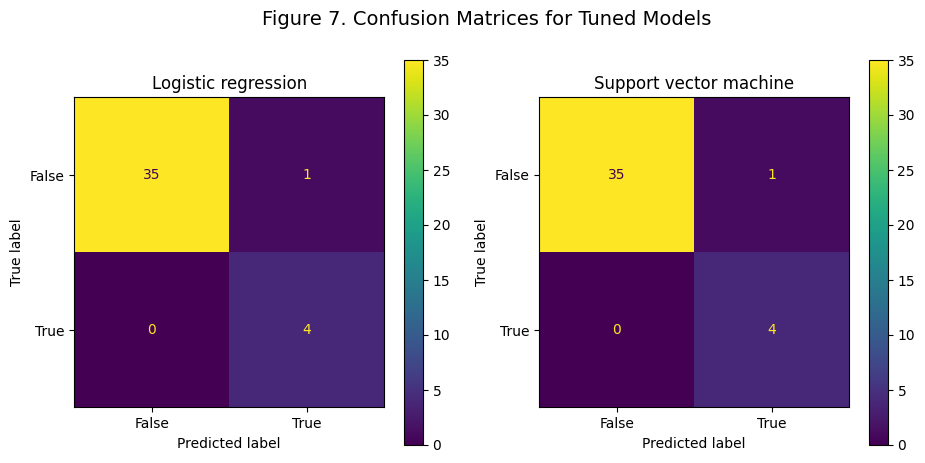

In [35]:
# Confusion matrices for tuned models

fig, ax = plt.subplots(1, 2, figsize=(11,5))
fig.suptitle('Figure 7. Confusion Matrices for Tuned Models', fontsize=14)

ax[0].set_title("Logistic regression")
ax[1].set_title("Support vector machine")

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(y_test, lrc2_predictions),
    display_labels=[False, True]).plot(ax=ax[0])

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(y_test, svmc2_predictions),
    display_labels=[False, True]).plot(ax=ax[1])

# Predictors of mortality

This final section directs attention to the predictors of mortality in this data set. The following table reports the coefficients (in the `coef` column) of the features in a logistic model regressing mortality on the 17 features. These should be interpreted as average changes in the log odds of expiring per unit change in the feature, controlling for all the other features (or patient group differences) in the model. For example, the coefficient for age is 0.1051. This means the log odds of expiring in the hospital increase by an average of 0.1051 for each additional year of age. The p-values can be interpreted as usual as the statistical significance of the coefficient.

In [36]:
# Logistic model coefficients
y2, X2 = dmatrices('expired ~ age + charlson_comorbidity_index + white_blood_cells + scr_baseline +  glucose + d_bypass_procedure + d_extraction_procedure + vanco_duration + clindamycin_duration_hrs + clindamycin_doses + linezolid_doses + linezolid_duration_hrs', data = df_17, return_type='dataframe')

mod = sm.Logit(y2, X2)
res = mod.fit(maxiter=100000)
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.132936
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                expired   No. Observations:                  158
Model:                          Logit   Df Residuals:                      145
Method:                           MLE   Df Model:                           12
Date:                Thu, 31 Jul 2025   Pseudo R-squ.:                  0.6500
Time:                        02:24:51   Log-Likelihood:                -21.004
converged:                       True   LL-Null:                       -60.014
Covariance Type:            nonrobust   LLR p-value:                 9.829e-12
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -6.3189      3.084     -2.049      0.040     

According to this table, the only statistically significant predictors of mortality are
- Charlson comorbidity index
- White blood cells
- Bypass procedure (a very risky procedure)
- Vancomycin duration
- Clindamycin duration
- Clindamycin doses

---
# Discussion

The purpose of this project was to apply unsupervised and supervised machine learning methods to clinical data from patients afflicted with necrotizing fasciitis and other severe skin and soft tissue infections to develop a model that predicts mortality. This project may be the first machine learning study of this disease state.

This project had three primary goals:

1. **Identify clinically meaningful clusters of patients based on selected features**. K-means clustering appears to have accomplished this goal. From among the 15 features the algorithim found three clusters of patients that appeared to be linearly separable and had an acceptable Silhouette score. Although patients in these clusters died at different rates, this feature was not ultimately a statistically significant feature in the final regression model of mortality. Despite this disappointing result, such clustering methods may be worth additional study for their potential to make effective use of growing volumes of medical data being collected by eletronic health record systems.

2. **Build a supervised machine learning model that would learn from training data to predict mortality in a test set with high levels of accuracy and recall**. The two models tested, a logistic regression model and a support vector machine, performed exceptionally well with high levels of accuracy in both the training and test sets and minimal overfitting. Tuning the models improved the fit of the models.

3. **Isolate the most important predictors of mortality** in patients with this disease state. The information to achieve this goal was not bivariate feature correlations with the target but regression coefficients that represent the net effect of the feature on the target controlling for all other features in the model. The strongest statistically significant features from this model were

> - Charlson comorbidity_index
> - Clindamycin duration
> - Vancomycin duration
> - Clindamycin doses
> - White blood cells
> - Bypass procedure

This project is limited in several critical ways. One is **feature selection**. I queried the initial array of features from the source data tables based in small part on clinical background knowledge and in large part on data availability; I queried features that were most readily available among the patients in the data set. These may not have been the most appropriate or necessary clinical features. Also not included were time-based features. No doubt time is of the essence when treating a patient with NF.

A second limitation is **sample size**. At 158 patients, the sample size was small which imposed constraints on machine learning efforts, perhaps chief among them being the number of features that can be investigated. Finally, the project employed only a few among a wide range of machine learning methods. No doubt more, or more appropriate, models could or should have been used to investigate this data set.

In light of these limitations, one might view this project as an exploratory pilot study that sheds initial light on this topic and these methods. Future projects with larger samples and more appropriate feature sets might be better able to support clinical decisionmaking.

---
# References

[1] Pan Z, Jin A, Brenneman B, Huber J. Evaluating the Safety and Efficacy of Using Clindamycin vs. Linezolid for Necrotizing Fasciitis. 2023. Residency Project in Progress. Providence Swedish Pharmacy.

[2] Hsiao C-T, Chang C-P, Huang T-Y, Chen Y-C, Fann W-C (2020) Prospective Validation of the Laboratory Risk Indicator for Necrotizing Fasciitis (LRINEC) Score for Necrotizing Fasciitis of the Extremities. PLoS ONE 15(1): e0227748. https://doi.org/10.1371/journal.pone.0227748

[3] Arif, N. Yousfi, S., & Vinnard, C. (2016). Deaths from necrotizing fasciitis in the United States, 2003–2013. Epidemiology & Infection, 144(6), 1338-1344. https://doi.org/10.1017/S0950268815002745

[4] Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

[5] Johnson, A., Bulgarelli, L., Pollard, T., Horng, S., Celi, L. A., & Mark, R. (2023). MIMIC-IV (version 2.2). PhysioNet. https://doi.org/10.13026/6mm1-ek67.

[6] Johnson, A.E.W., Bulgarelli, L., Shen, L. et al. MIMIC-IV, a freely accessible electronic health record dataset. Sci Data 10, 1 (2023). https://doi.org/10.1038/s41597-022-01899-x

[7] Dorazio J, Chiappelli AL, Shields RK, Tsai YV, Skinker P, Nabozny MJ, Bauza G, Forsythe R, Rosengart MR, Gunn SR, Marini R. Clindamycin Plus Vancomycin Versus Linezolid for Treatment of Necrotizing Soft Tissue Infection. InOpen Forum Infectious Diseases 2023 May 11 (p. ofad258). Oxford University Press.

[8] Pedregosa F, Varoquaux G, Gramfort A, Michel V, Thirion B, Grisel O, Blondel M, Prettenhofer P, Weiss R, Dubourg V, Vanderplas J. Scikit-learn: Machine learning in Python. the Journal of machine Learning research. 2011 Nov 1;12:2825-30.